In [ ]:
# default_exp image_blending

# Image Blending

# Task 5: Image blending in gradient area
> whatisit

Implementujte techniku bezešvého skládání obrazů v gradientní oblasti. Pro výpočet výsledného lineárního systému použijte iterativní metodu Gauss-Seidel. Demonstrujte funkčnost výsledné implementace na příkladě složení dvou snímků se znatelně odlišnou úrovní expozice.

In [ ]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import trange
from dzotools.utils import imgload, arr2img
from IPython.display import clear_output

background = imgload('data/blending/windows_mini_normal.png', convert="L") / 256.0
foreground = imgload('data/blending/windows_mini_dark.png', convert="L") / 256.0

# Load the mask and binarize it to 0, 1 and invert
mask = imgload('data/blending/windows_mini_mask.png', convert="L")
mask = 1 - np.round(mask / 256.0).astype(int)

### Sparse Matrix
In order to save space (the $A$ matrix could be actually $n^4$ large where $n$ is the image width) we will implement our own sparse matrix implementation along with a numpy dot product.

In [ ]:
# exports
class SparseMatrix:
    def __init__(self, heigth, width, safe=False):
        self.heigth, self.width = heigth, width
        self.safe = safe
        
        # Working memory to speed up reallocation
        self.out = np.zeros(width, dtype="float32")        
        self.rows = {
            r: {} for r in range(heigth)
        }
        
    @property
    def shape(self):
        return (self.heigth, self.width)
    
    def to_numpy(self) -> np.array:
        arr = np.zeros((self.heigth, self.width), dtype="float32")
        for y, row in self.rows.items():
            k = np.fromiter(row.keys(), dtype="int32")
            arr[y, k] = np.fromiter(row.values(), dtype="float32")
        return arr
        
    def __getitem__(self, location):
        """Get the value or default to zero."""
        y, x = location
        
        return self.rows[y].get(x, 0)
    
    def __setitem__(self, location, value):
        """Set the value in a sparse format."""
        y, x = location
        
        row = self.rows[y]
        if self.safe and x in row and row[x] != value:
            print(f"Overwriting row/col {y}/{x} value from {row[x]} to {value}!")
        
        self.rows[y][x] = value
        
    __array_priority__ = 10000
        
    def __mul__(self, x: np.array) -> np.array:
        """Multiplication with a numpy array."""
        self.out = np.zeros_like(self.out, dtype="float32")
        for y, row in self.rows.items():            
            k = np.fromiter(row.keys(), dtype="int32")
            v = np.fromiter(row.values(), dtype="float32")
            self.out[y] = np.dot(x.take(k), v)
            
        return self.out

In [ ]:
s = SparseMatrix(2, 2)
s[0, 0] = 2
s[1, 0] = 1

assert s[0, 0] == 2
assert s[1, 1] == 0
assert s[1, 0] == 1

assert s.shape == (2, 2)

np.testing.assert_array_equal(
    s * np.array([1, 1]), 
    np.array([2., 1.])
)

np.testing.assert_array_equal(
    s.to_numpy(),
    np.array([[2., 0.], [1., 0.]])
)

### Edge Padded Array
Neglect the borders by returning 0 if out of bounds. Wraps around a numpy array.

In [ ]:
class WrappedNdArray:
    """Wraps an ndarray and only returns value if within bounds."""
    def __init__(self, array: np.ndarray):
        assert len(array.shape) == 2, "Only 2D arrays are supported."
        self.array = array
        
    def is_inside(self, location):
        return all([
            0 <= location[0] < self.array.shape[0],
            0 <= location[1] < self.array.shape[1]
        ])
        
    def __getitem__(self, location):
        if not self.is_inside(location):
            return 0
        return self.array[location]
        
    def __setitem__(self, location, value):
        if self.is_inside(location):
            self.array[location] = value

In [ ]:
arr = np.array([[1, 2, 3], [4, 5, 6]])
wrapped = WrappedNdArray(arr)
assert wrapped[10, 0] == 0

### Utuility functions
Flatten and unflatten the image pixels.

In [ ]:
def unflatten(arr: np.array, blueprint=mask.shape):
    return np.reshape(arr, blueprint)

In [ ]:
np.testing.assert_array_equal(
    unflatten(arr.flatten(), arr.shape),
    arr
)

### Initialize the matrixes
Initialize the sparse matrix $A$, and vectors $b$ and $x$ (also called $I$ in lecture notes). The target vector $x$ is initialized as zeros.

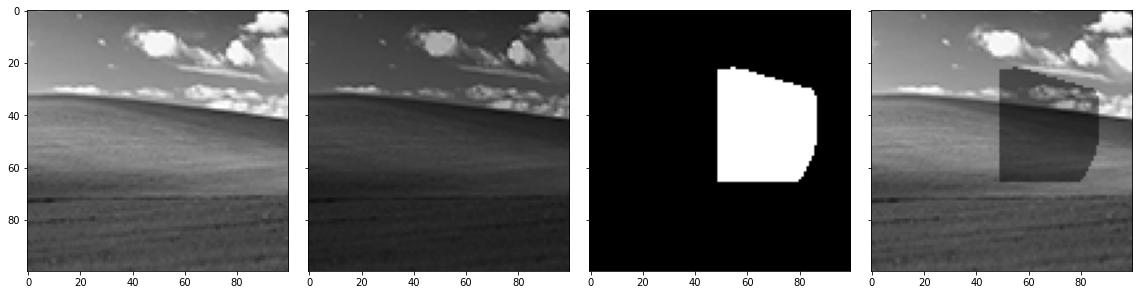

In [ ]:
masked = np.where(mask, foreground, background)

fig, ax = plt.subplots(ncols=4, figsize=(16, 4), sharey=True)
ax[0].imshow(background, vmin=0, vmax=1, cmap='gray')
ax[1].imshow(foreground, vmin=0, vmax=1, cmap='gray')
ax[2].imshow(mask, vmin=0, vmax=1, cmap='gray')
ax[3].imshow(masked, vmin=0, vmax=1, cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
A, b = prepare_data(mask, foreground, background)

### Gauss-Seidel Update

In [ ]:
_output = WrappedNdArray(background)
heigth, width = mask.shape

for step in trange(1000):
    clear_output(wait=True)
    
    nx = np.empty_like(b)
    for y in range(heigth):
        for x in range(width):
            neighbours = sum([_output[y-1, x], _output[y+1, x], _output[y, x-1], _output[y, x+1]])
            nx[y, x] = neighbours / 4 - gx[y, x] - gy[y, x] # b[y, x]
    
    _output.array = nx
    
    img = np.reshape(nx, mask.shape)
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    plt.show()

 11%|█         | 109/1000 [00:23<03:09,  4.70it/s]


KeyboardInterrupt: 

### Conjugate Gradient Update

In [ ]:
def conjugate_gradient_update(A, x, b, mult=1):
    grad = b - A*x
    alpha = np.linalg.norm(grad)/(grad@(A*grad))
    return x + (alpha * mult) * grad

In [ ]:
from IPython.display import clear_output

results = {}
x = np.zeros_like(foreground, dtype="float32").flatten()
b_flat = b.flatten()

for step in trange(100):
    clear_output(wait=True)
    x = conjugate_gradient_update(A, x, b_flat, 500)
    
    # Show the image in the Jupyter Notebook
    img = unflatten(x)
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    plt.show()

 23%|██▎       | 23/100 [00:32<01:49,  1.42s/it]


KeyboardInterrupt: 